In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [4]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of berylium hydroxide BeH2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 
'''

import numpy as np
import matplotlib.pyplot as plt
import time

from collections import Counter

from qiskit.circuit.library import EfficientSU2

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.algorithms.optimizers import SLSQP, COBYLA

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow, tweaked_derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 1

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -19.04

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom = "Be 0 0 0; H 0 0 1.3264; H 0 0 -1.3264",  
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
num_particles = problem.num_particles
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

-12.095058424846787 * IIIIIIIIIIIIII
+ 2.215991689792136 * IIIIIIIIIIIIIZ
- 0.03204350197716009 * IIIIIIIIIIIIZX
+ 0.03204350197716009 * IIIIIIIIIIIIIX
+ 0.025430669761538717 * IIIIIIIIYIYIXX
- 0.025430669761538717 * IIIIIIIIXZYIXY
+ 0.007263588273459966 * IIIIIIIIIIIIZZ
- 0.027791569929431513 * IIIIIIIIYIYIXZ
+ 0.027791569929431513 * IIIIIIIIXZYIYI
- 0.022996019773985382 * IIIIIIIIIIIZII
- 0.00999192921498608 * IIIIIIIYZIYXZI
+ 0.00999192921498608 * IIIIIIIXZIYYZI
- 0.14776127358473878 * IIIIIIIIIIZZZI
- 0.14776127358473895 * IIIIIIIIIZIIII
- 0.26516938577667803 * IIIIIIIIZZIIII
- 0.47664570727139843 * IIIIIIIZIIIIII
+ 2.215991689792131 * IIIIIIZZZIZIII
+ 0.03204350197716013 * IIXIXYYZZIZIII
+ 0.03204350197716013 * IIXIXXXIIIIIII
+ 0.025430669761538724 * XYZIIIYZZIZIII
+ 0.025430669761538724 * XXZIIIXIIIIIII
+ 0.007263588273458978 * IIIIIZIIIIIIII
- 0.027791569929431485 * XYYIXXIIIIIIII
+ 0.027791569929431485 * XXYIXYIIIIIIII
- 0.02299601977398566 * IIIIZZIIIIIIII
- 0.0099919292149861

In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

#print(hamiltonian_terms)
#print(weights)







'''
Reformatting the Hamiltonian for use in estimate_exp(): removing all entries with Pauli I. 
'''

hamiltonian_terms_XYZ = []

for term in hamiltonian_terms:
    term_XYZ = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZ.append(pauli)
    hamiltonian_terms_XYZ.append(term_XYZ)         
    
#print(hamiltonian_terms_XYZ)

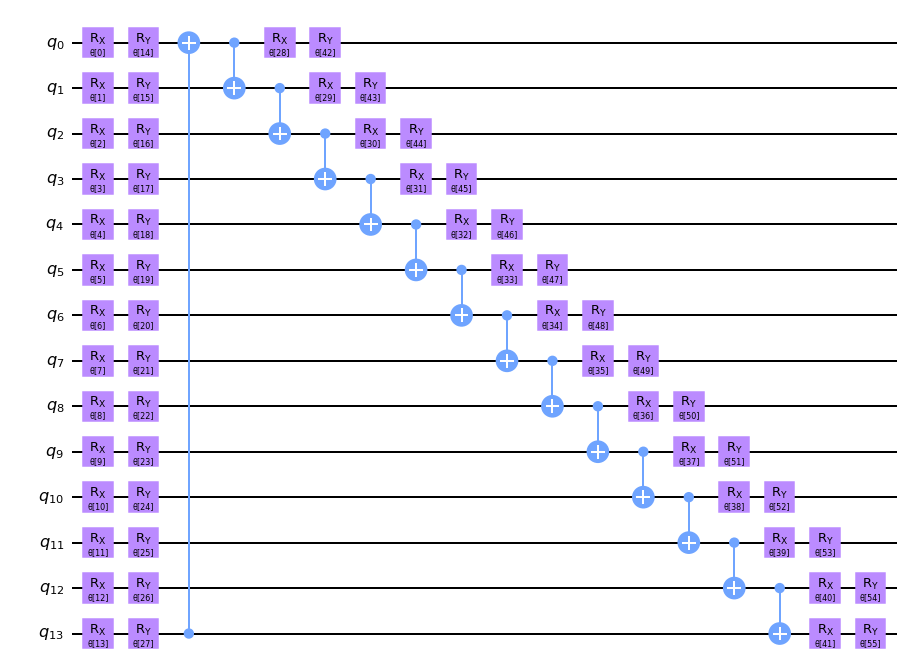

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1

ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [5]:
'''
Generate derandomized Hamiltonian
'''

num_obs_evals = 1   

derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms, 
                                                                num_obs_evals, system_size, weight=weights)

tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
counts = Counter(tuples)
print('Derandomised Hamitlonian:', counts)

Derandomised Hamitlonian: Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 666})


In [6]:
'''
Define the cost function
'''

backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas


def objective_function(params):
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    from collections import Counter
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in derandomized_hamiltonian)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)
            
        
    cost_history.append(cost)
    
    return cost


GROUND STATE ENERGY FOUND =  -12.16048858188301
Execution time =  00:01:16


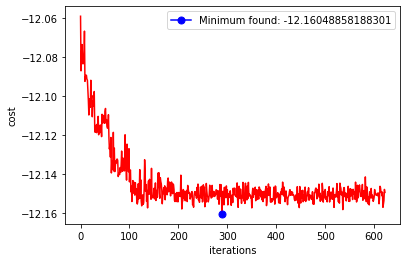

In [7]:
'''
Classical optimisation step
'''

# Counter for the execution time
start_time = time.time()


# Classical optimizer
optimizer = COBYLA(maxiter=5000)   

# Collect the expectation value from each experiment
expectation_values = []


for iteration in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=params)
    expectation_values.append(min(cost_history))
    print("GROUND STATE ENERGY FOUND = ", min(cost_history))
    
    if iteration == num_experiments-1:
        
        num_points = len(cost_history)
        min_energy = min(cost_history)
        min_ener_idx = cost_history.index(min_energy)
        minimum_str = str(min_energy)

        plt.plot([i for i in range(num_points)], [cost_history[i] for i in range(num_points)], 'r')
        plt.plot(min_ener_idx, min_energy, 'b', marker="o", markersize=7, label='Minimum found: '+ minimum_str)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.legend(loc=1)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [8]:
'''
Calculate the error.
'''

rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                       for i in range(num_experiments)])/num_experiments)
print(f"The average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")


The average root-mean-squared error for derandomized classical shadow: 6.879511418116989


In [8]:
'''
Above we have assumed a particular ground state energy for the molecule of interest.
Below we corroborate this assumption using a classical minimum eigensolver on our Hamiltonian.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy:\n', res) 

/tmp/ipykernel_293/3874215217.py:6: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  converter = QubitConverter(BravyiKitaevMapper())


Electronic ground state energy:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.986315509469
  - computed part:      -18.986315509469
~ Nuclear repulsion energy (Hartree): 3.391138640546
> Total ground state energy (Hartree): -15.595176868923
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
